In [23]:
%matplotlib notebook

In [24]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Reload the line

In [25]:
line = xt.Line.from_json('pimms_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


## Power extraction sextupoles

In [26]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

### Moved analysis from the previous code into a function

In [27]:
from phase_space_characterization import characterize_phase_space_at_septum

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


<IPython.core.display.Javascript object>


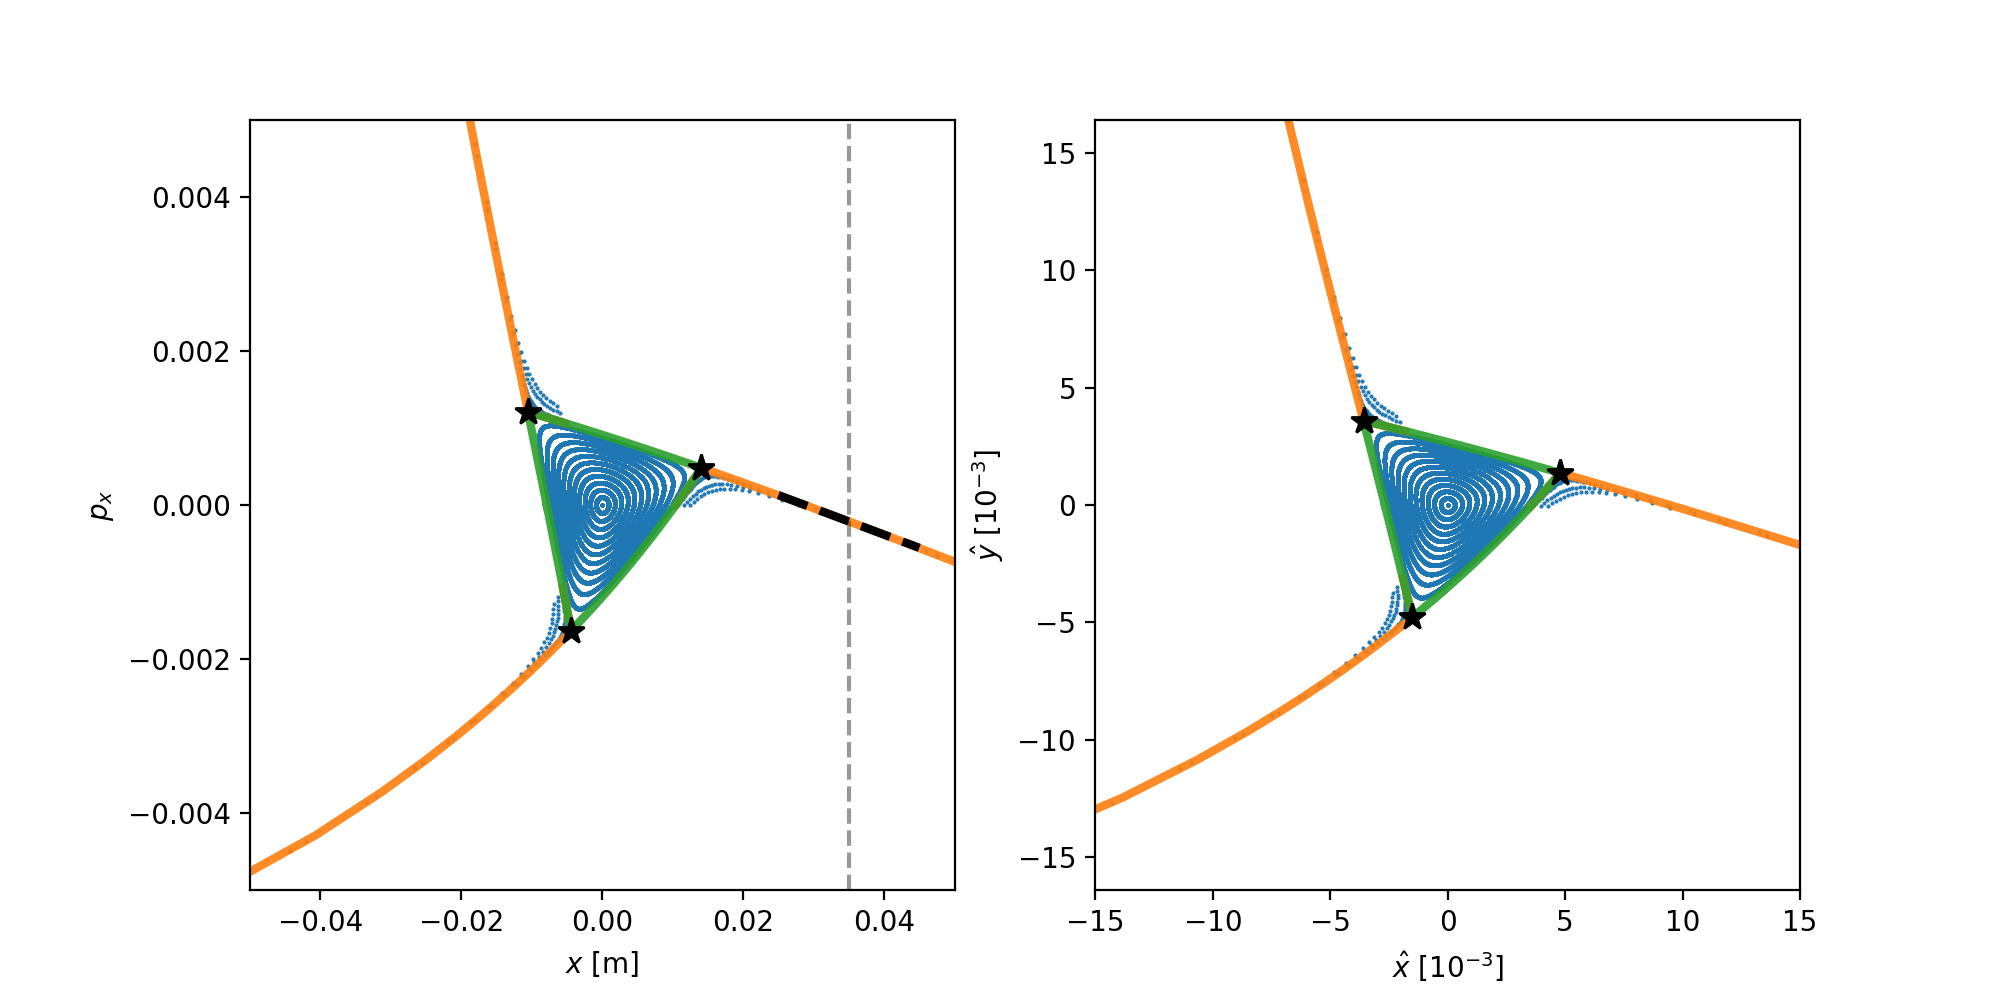

{'dpx_dx_at_septum': -0.03424216378131333,
 'stable_area': 6.535788015798929e-05,
 'x_fp': array([-0.01052962, -0.00442341,  0.01406426]),
 'px_fp': array([-0.01052962, -0.00442341,  0.01406426]),
 'x_norm_fp': array([-0.00358398, -0.0015056 ,  0.00478707]),
 'px_norm_fp': array([-0.00358398, -0.0015056 ,  0.00478707])}

In [28]:
characterize_phase_space_at_septum(line, plot=True)

In [30]:
# Time the chracterization function (with no plot)
%time res = characterize_phase_space_at_septum(line)

CPU times: user 590 ms, sys: 1.74 s, total: 2.33 s
Wall time: 296 ms


## Resonance optimization

In [39]:
# To use the results from our function in an optimization
# we need to wrap the function in an Action class

# Define action class
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line, num_turns=1000)
        return out
    
# Build action object
action = ActionSeparatrix(line)

In [40]:
# Test the action
action.run()

{'dpx_dx_at_septum': 0.03010331274050114,
 'stable_area': 9.993342995435351e-05,
 'x_fp': array([ 0.01239043, -0.01754442,  0.00658227]),
 'px_fp': array([ 0.01239043, -0.01754442,  0.00658227]),
 'x_norm_fp': array([ 0.00421735, -0.00597161,  0.00224041]),
 'px_norm_fp': array([ 0.00421735, -0.00597161,  0.00224041])}

In [41]:
# From the action we can create optimization targets
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [42]:
# State before optimization
opt.target_status()

Target status:                          
id state tag tol_met     residue current_val target_val description                                 
 0 ON           True  -6.657e-08 9.99334e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON           True 0.000103313   0.0301033       0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


### How to use an external python optimizer

We could get the solution simply calling `opt.solve` which uses the Xsuite internal optimizer.

For some problems you might want to use a different optimizer (e.g. a derivative-free one) because it is more suited to your problem. For example here we show how to apply the [Py-BOBYQA optimizer](https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/index.html) to our non-linear match problem.

In [43]:
# We extract a the merit function from our Xsuite optimizer objects
merit_function = opt.get_merit_function(
    return_scalar=True, # Py-BOBYQA wants a scalar merit function
    check_limits=False) # Py-BOBYQA wants to explore a bit outside the enforced limits

In [44]:
# Extract limits and starting point from merit function
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [45]:
# Search optimum using Py-BOBYQA
import pybobyqa
soln = pybobyqa.solve(merit_function, x0=x0,
            bounds=bounds.T, # wants them transposed 
            rhobeg=5, rhoend=1e-4, maxfun=30,
            objfun_has_noise=True, # <-- helps in this case
            seek_global_minimum=True)
soln.x

array([4.89867942, 0.31718437])

In [46]:
# Set found solution in the line
merit_function.set_x(soln.x)

# Log solution in Xsuite optimizer log
opt.tag('bobyqa solution')
opt.log()

Table: 2 rows, 14 cols
iteration     penalty alpha tag             tol_met target_active hit_limits vary_active  vary_0 ...
        0 0.000103527    -1                 yy      yy            nn         yy          4.85545
        1 8.78187e-05    -1 bobyqa solution yy      yy            nn         yy          4.89868

In [47]:
opt.target_status()

Target status:                           
id state tag tol_met     residue current_val target_val description                                 
 0 ON           True -3.2417e-07 9.96758e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON           True 8.16166e-05   0.0300816       0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


In [48]:
merit_function(soln.x)

7.712129080931275e-09

In [ ]:
x0 = opt.get_x

In [ ]:
opt._err._set_x([0.1, 0.2])

In [ ]:
opt.vary_status()

In [ ]:
characterize_phase_space_at_septum(line, num_turns=1000, plot=True)

In [ ]:
line.to_json('pimms_02_tuned.json')